In [33]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle



# 固定随机数种子
tf.random.set_seed(23)
np.random.seed(23)

# sku_info
NUM_ITEM_FIRST_CATE = 2 + 1
NUM_ITEM_SECOND_CATE = 7 + 1
NUM_ITEM_THIRD_CATE = 44 + 1
NUM_BRAND = 126 + 1
# sku_prom
NUM_PROMOTION_TYPE = 7 + 1
# store_weather
NUM_WEATHER_TYPE = 303 + 1

In [2]:
class DataManager:
    def __init_data(self, datapath):
        data_sku_info = pd.read_csv(os.path.join(datapath, 'sku_info.csv'))
        data_sku_prom = pd.read_csv(os.path.join(datapath, 'sku_prom.csv'))
        data_store_weather = pd.read_csv(os.path.join(datapath, 'store_weather.csv'))
        data_sku_sales = pd.read_csv(os.path.join(datapath, 'sku_sales.csv'))
        data_prices = pd.read_csv(os.path.join(datapath, 'sku_price_and_status.csv'))

        data_sku_sales['date'] = pd.to_datetime(data_sku_sales['order_time'])
        data_sku_sales['date'] = data_sku_sales['date'].dt.date
        data_sku_prom['date'] = pd.to_datetime(data_sku_prom['date'])
        data_sku_prom['date'] = data_sku_prom['date'].dt.date
        data_store_weather['date'] = pd.to_datetime(data_store_weather['date'])
        data_store_weather['date'] = data_store_weather['date'].dt.date
        data_sku_sales = data_sku_sales.groupby(['store_id', 'sku_id', 'date', 'channel']).count().reset_index()
        data_sku_sales = data_sku_sales[['store_id', 'sku_id', 'date', 'channel', 'order_id']].reset_index()
        data_sku_sales.rename(columns={'order_id': 'count'}, inplace=True)
        data_sku_sales.drop("index", axis=1, inplace=True)
        data_prices['date'] = pd.to_datetime(data_prices['date'])
        data_prices['date'] = data_prices['date'].dt.date

        self.COUNT_MAX = data_sku_sales['count'].max()
        self.THRESHOLD_MAX = data_sku_prom['threshold'].max()
        self.PRICE_MAX = data_prices['original_price'].max()

        self.data_sku_info = data_sku_info
        self.data_sku_prom = data_sku_prom
        self.data_store_weather = data_store_weather
        self.data_sku_sales = data_sku_sales
        self.data_prices = data_prices


    def __init__(self, datapath):
        self.__init_data(datapath)
    
    def get_single_data(self, store_id, sku_id, channel, split_date="2023-08-16"):
        data_sales_single = self.data_sku_sales[(self.data_sku_sales['store_id'] == store_id) & (self.data_sku_sales['sku_id'] == sku_id) & (self.data_sku_sales['channel'] == channel)].copy()
        data_info_single = self.data_sku_info[self.data_sku_info['sku_id'] == sku_id].copy()
        data_prom_single = self.data_sku_prom[(self.data_sku_prom['store_id'] == store_id) & (self.data_sku_prom['sku_id'] == sku_id) & (self.data_sku_prom['channel'] == channel)].copy()
        data_weather_single = self.data_store_weather[self.data_store_weather['store_id'] == store_id].copy()
        data_prices_single = self.data_prices[(self.data_prices['store_id'] == store_id) & (self.data_prices['sku_id'] == sku_id)].copy()

        date_min = data_sales_single['date'].min()
        date_max = "2023-09-14"
        date_range = pd.date_range(date_min, date_max)
        date_range_df = pd.DataFrame(date_range, columns=['date'])
        date_range_df['date'] = date_range_df['date'].dt.date

        data_sales_single = pd.merge(data_sales_single, date_range_df, on=['date'], how='right')
        data_sales_single['store_id'].fillna(store_id, inplace=True)
        data_sales_single['sku_id'].fillna(sku_id, inplace=True)
        data_sales_single['channel'].fillna(channel, inplace=True)

        data_prices_single = pd.merge(data_prices_single, date_range_df, on=['date'], how='right')
        data_prices_single['store_id'].fillna(store_id, inplace=True)
        data_prices_single['sku_id'].fillna(sku_id, inplace=True)
        data_prices_single['salable_status'].fillna(0, inplace=True)
        data_prices_single['stock_status'].fillna(0, inplace=True)
        data_prices_single['original_price'].ffill(inplace=True)
        data_prices_single['original_price'] = data_prices_single['original_price'] / self.PRICE_MAX

        # 对sku_prom进行处理
        data_prom_single['curr_day'] = data_prom_single['curr_day'] / data_prom_single['total_days']
        data_prom_single.drop(['total_days'], axis=1, inplace=True)
        data_prom_single['threshold'] = data_prom_single['threshold'] / self.THRESHOLD_MAX
        data_prom_single.drop(['promotion_id'], axis=1, inplace=True)
        # 先保存每个日期下最大的discount_off的那一行
        data_prom_single = data_prom_single.groupby(['date']).max().reset_index()
        data_prom_single = pd.merge(data_prom_single, date_range_df, on=['date'], how='right')
        # 填充缺失值
        data_prom_single['store_id'].fillna(store_id, inplace=True)
        data_prom_single['sku_id'].fillna(sku_id, inplace=True)
        data_prom_single['channel'].fillna(channel, inplace=True)
        data_prom_single.fillna(0, inplace=True)

        # 合并data_sales_single, data_info_single, data_prom_single, data_weather_single, data_prices_single
        data_single = pd.merge(data_sales_single, data_info_single, on=['sku_id'], how='left')
        data_single = pd.merge(data_single, data_prom_single, on=['store_id', 'sku_id', 'date', 'channel'], how='left')
        data_single = pd.merge(data_single, data_weather_single, on=['store_id', 'date'], how='left')
        data_single = pd.merge(data_single, data_prices_single, on=['store_id', 'sku_id', 'date'], how='left')
        # 对于salable_status为1的count缺失值置为0
        data_single.loc[(data_single['salable_status'] == 1) & (data_single['count'].isnull()), 'count'] = 0
        data_single['count'].ffill(inplace=True)
        # 将sable_status和stock_status去除
        data_single.drop(['salable_status', 'stock_status'], axis=1, inplace=True)
        # 加入是否是周末的特征
        data_single['is_weekend'] = data_single['date'].apply(lambda x: 1 if x.weekday() in [5, 6] else 0)

        train_single = data_single[data_single['date'] <= pd.to_datetime(split_date).date()].copy()
        test_single = data_single[data_single['date'] > pd.to_datetime(split_date).date()].copy()
        train_single.drop(['store_id', 'sku_id', 'date', 'channel'], axis=1, inplace=True)
        test_single.drop(['store_id', 'sku_id', 'date', 'channel'], axis=1, inplace=True)

        train_label = train_single['count']
        train_features = train_single.drop(['count'], axis=1)
        test_label = test_single['count']
        test_features = test_single.drop(['count'], axis=1)

        # 将训练集和测试集划分为多输入
        train_features = [train_features['item_first_cate_cd'], train_features['item_second_cate_cd'],
                        train_features['item_third_cate_cd'], train_features['brand_code'],
                        train_features['promotion_type'], train_features['weather_type'],
                        train_features.drop(['item_first_cate_cd', 'item_second_cate_cd', 'item_third_cate_cd',
                                            'brand_code', 'promotion_type', 'weather_type'], axis=1)]
        test_features = [test_features['item_first_cate_cd'], test_features['item_second_cate_cd'],
                            test_features['item_third_cate_cd'], test_features['brand_code'],
                            test_features['promotion_type'], test_features['weather_type'],
                            test_features.drop(['item_first_cate_cd', 'item_second_cate_cd', 'item_third_cate_cd',
                                                'brand_code', 'promotion_type', 'weather_type'], axis=1)]
        train_label = train_label.values
        test_label = test_label.values

        # 对label进行一下归一化
        train_label = train_label / self.COUNT_MAX
        test_label = test_label / self.COUNT_MAX

        return train_features, train_label, test_features, test_label

In [3]:
data_manager = DataManager(datapath='./data')

In [4]:
train_features, train_label, test_features, test_label = data_manager.get_single_data(store_id=1, sku_id=1, channel=1)
for i in train_features:
    print(i[:1])
print(test_label)

0    1
Name: item_first_cate_cd, dtype: int64
0    1
Name: item_second_cate_cd, dtype: int64
0    1
Name: item_third_cate_cd, dtype: int64
0    1
Name: brand_code, dtype: int64
0    0.0
Name: promotion_type, dtype: float64
0    7
Name: weather_type, dtype: int64
   curr_day  threshold  discount_off  min_temperature  max_temperature  \
0       0.0        0.0           0.0             0.64              0.8   

   original_price  is_weekend  
0        0.228152           0  
[0.00172712 0.         0.00345423 0.         0.         0.00172712
 0.         0.00690846 0.         0.00518135 0.01036269 0.00345423
 0.         0.00172712 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [5]:
with open('model/embedding/item_first_cate_embedding_weights.pkl', 'rb') as f:
    item_first_cate_embedding_weights = pickle.load(f)
with open('model/embedding/item_second_cate_embedding_weights.pkl', 'rb') as f:
    item_second_cate_embedding_weights = pickle.load(f)
with open('model/embedding/item_third_cate_embedding_weights.pkl', 'rb') as f:
    item_third_cate_embedding_weights = pickle.load(f)
with open('model/embedding/brand_embedding_weights.pkl', 'rb') as f:
    brand_embedding_weights = pickle.load(f)
with open('model/embedding/promotion_type_embedding_weights.pkl', 'rb') as f:
    promotion_type_embedding_weights = pickle.load(f)
with open('model/embedding/weather_type_embedding_weights.pkl', 'rb') as f:
    weather_type_embedding_weights = pickle.load(f)

In [147]:
HIDDEN_UNITS = 64

# 建立模型
class MQRNNModel(Model):
    def __init__(self):
        super(MQRNNModel, self).__init__()
        # self.rnn = layers.LSTM(HIDDEN_UNITS, return_sequences=True)  # 可以选择GRU或其他RNN层
        self.rnn = layers.Bidirectional(layers.LSTM(HIDDEN_UNITS, return_sequences=True))  # 使用双向 LSTM
        # self.fc = layers.TimeDistributed(layers.Dense(1))  # 针对序列的每个时间点预测
        # self.fc1 = layers.TimeDistributed(layers.Dense(32, activation='relu'))  # 新的全连接层
        self.fc2 = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))
        # 嵌入层
        self.item_first_cate_embedding = Embedding(input_dim=NUM_ITEM_FIRST_CATE, output_dim=8, input_length=1,
                                            name='item_first_cate_embedding', trainable=False, weights=[item_first_cate_embedding_weights])
        self.item_second_cate_embedding = Embedding(input_dim=NUM_ITEM_SECOND_CATE, output_dim=8, input_length=1,
                                            name='item_second_cate_embedding', trainable=False, weights=[item_second_cate_embedding_weights])
        self.item_third_cate_embedding = Embedding(input_dim=NUM_ITEM_THIRD_CATE, output_dim=8, input_length=1,
                                            name='item_third_cate_embedding', trainable=False, weights=[item_third_cate_embedding_weights])
        self.brand_embedding = Embedding(input_dim=NUM_BRAND, output_dim=8, input_length=1,
                                            name='brand_embedding', trainable=False, weights=[brand_embedding_weights])
        self.promotion_type_embedding = Embedding(input_dim=NUM_PROMOTION_TYPE, output_dim=8, input_length=1,
                                            name='promotion_type_embedding', trainable=False, weights=[promotion_type_embedding_weights])
        self.weather_type_embedding = Embedding(input_dim=NUM_WEATHER_TYPE, output_dim=8, input_length=1,
                                            name='weather_type_embedding', trainable=False, weights=[weather_type_embedding_weights])
        self.dropout = layers.Dropout(0.5)  # 添加一个新的 Dropout 层，0.5 是一个常见的起始值，但可以根据需要调整
        self.batch_norm = layers.BatchNormalization()  # 添加一个新的批量归一化层


    def call(self, inputs):
        [i_item_first_cate,
         i_item_second_cate,
         i_item_third_cate,
         i_brand,
         i_promotion_type,
         i_weather_type,
         i_other_features] = inputs
        
        i_item_first_cate = self.item_first_cate_embedding(i_item_first_cate)
        i_item_second_cate = self.item_second_cate_embedding(i_item_second_cate)
        i_item_third_cate = self.item_third_cate_embedding(i_item_third_cate)
        i_brand = self.brand_embedding(i_brand)
        i_promotion_type = self.promotion_type_embedding(i_promotion_type)
        i_weather_type = self.weather_type_embedding(i_weather_type)
        i_other_features = tf.reshape(i_other_features, [-1, 1, 7])
        x = tf.concat([i_item_first_cate, i_item_second_cate, i_item_third_cate,
                            i_brand, i_promotion_type, i_weather_type, i_other_features], axis=-1)
        x = self.rnn(x)
        x = self.dropout(x)
        x = self.batch_norm(x)
        # x = self.fc(x)
        # x = self.fc1(x)
        x = self.fc2(x)
        return x

Epoch 1/200
18/18 [==============================] - 4s 42ms/step - loss: 0.2523 - val_loss: 0.1836
Epoch 2/200
18/18 [==============================] - 0s 6ms/step - loss: 0.1875 - val_loss: 0.1337
Epoch 3/200
18/18 [==============================] - 0s 6ms/step - loss: 0.1305 - val_loss: 0.0888
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 0.0870 - val_loss: 0.0534
Epoch 5/200
18/18 [==============================] - 0s 6ms/step - loss: 0.0541 - val_loss: 0.0315
Epoch 6/200
18/18 [==============================] - 0s 6ms/step - loss: 0.0333 - val_loss: 0.0204
Epoch 7/200
18/18 [==============================] - 0s 6ms/step - loss: 0.0205 - val_loss: 0.0130
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 0.0146 - val_loss: 0.0087
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0063
Epoch 10/200
18/18 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 11

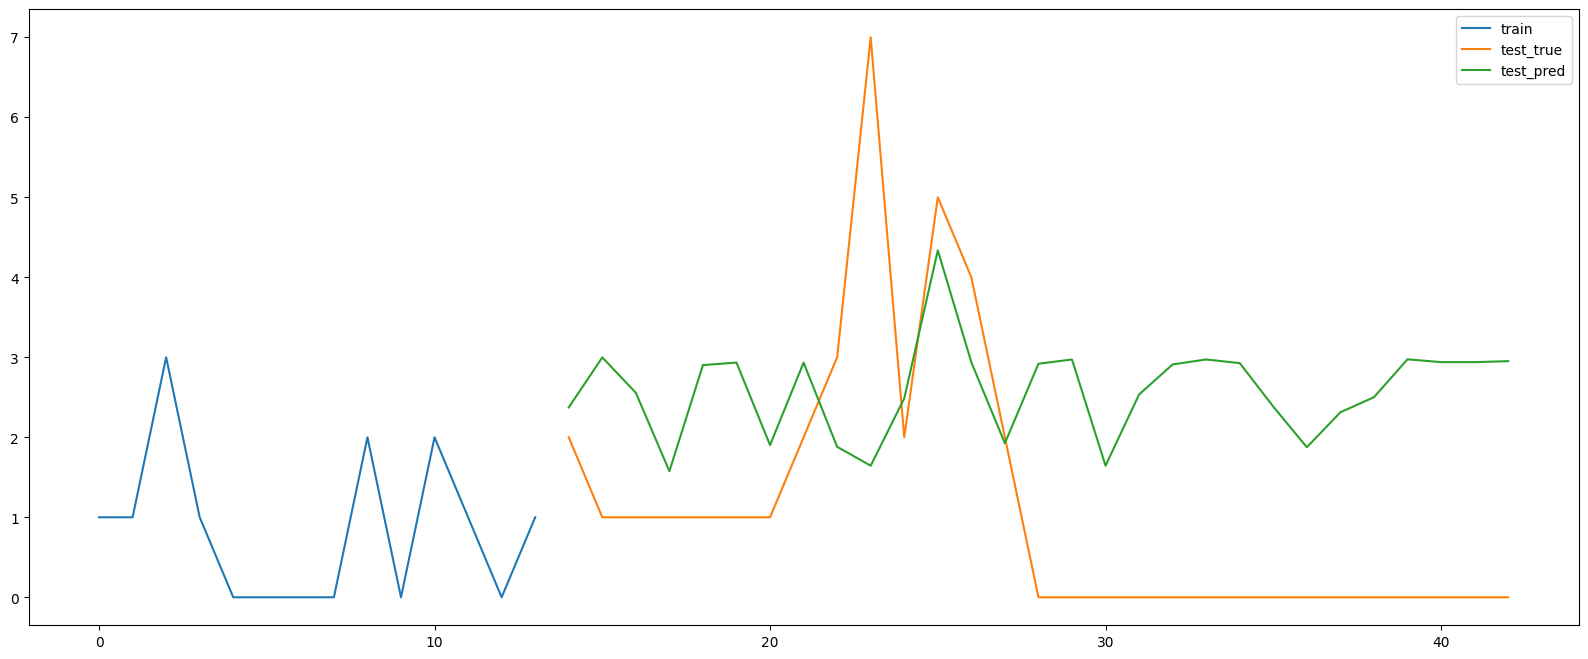

(array([2.3733191, 2.9985728, 2.5560024, 1.5759856, 2.9025393, 2.9335806,
        1.9025481, 2.9333594, 1.8810985, 1.6446648, 2.4856656, 4.336115 ,
        2.9370384, 1.9249761, 2.9192028, 2.9723444, 1.6446648, 2.534835 ,
        2.9106686, 2.9726036, 2.9267342, 2.382994 , 1.8754867, 2.3123024,
        2.5008698, 2.9745574, 2.939348 , 2.939348 , 2.9514155],
       dtype=float32),
 array([2., 1., 1., 1., 1., 1., 1., 2., 3., 7., 2., 5., 4., 2., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [148]:

def train(store_id, sku_id, channel, verbose=1, split_date="2023-08-16"):
    train_features, train_label, test_features, test_label = data_manager.get_single_data(store_id=store_id, sku_id=sku_id, channel=channel, split_date=split_date)
    # new_train_features = []
    # new_test_features = []
    # for i in train_features:
    #     new_train_features.append(i[6::7])
    # for i in test_features:
    #     new_test_features.append(i[6::7])
    # train_features = new_train_features
    # test_features = new_test_features
    # train_label = train_label[6::7]
    # test_label = test_label[6::7]
    model = MQRNNModel()
    model.compile(optimizer=Adam(0.001), loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=verbose, restore_best_weights=True)
    model.fit(train_features, train_label, epochs=200, verbose=verbose, callbacks=[early_stopping], validation_split=0.2, batch_size=32)
    model.save_weights(f'model/{store_id}_{sku_id}_{channel}/{store_id}_{sku_id}_{channel}_mqrnn_weights.tf')
    pred = model.predict(test_features)
    pred = pred.reshape(-1)
    # 将小于0的值置为0
    pred[pred < 0] = 0
    pred_label = pred * data_manager.COUNT_MAX
    # print(pred)
    test_label = test_label * data_manager.COUNT_MAX
    print("mse:", np.mean(np.square(pred_label - test_label)))
    plt.figure(figsize=(20, 8))
    plt.plot(range(14), (train_label * data_manager.COUNT_MAX)[-14:], label = 'train')
    plt.plot(range(14, 14 + test_label.shape[0]), test_label, label='test_true')
    plt.plot(range(14, 14 + pred_label.shape[0]),pred_label, label='test_pred')
    plt.legend()
    plt.show()
    return pred_label, test_label

train(store_id=1, sku_id=2, channel=1)

Epoch 1/200
18/18 [==============================] - 3s 34ms/step - loss: 0.2754 - val_loss: 0.1382
Epoch 2/200
18/18 [==============================] - 0s 5ms/step - loss: 0.2218 - val_loss: 0.1177
Epoch 3/200
18/18 [==============================] - 0s 5ms/step - loss: 0.1812 - val_loss: 0.0943
Epoch 4/200
18/18 [==============================] - 0s 5ms/step - loss: 0.1364 - val_loss: 0.0730
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 0.1034 - val_loss: 0.0561
Epoch 6/200
18/18 [==============================] - 0s 6ms/step - loss: 0.0729 - val_loss: 0.0380
Epoch 7/200
18/18 [==============================] - 0s 5ms/step - loss: 0.0549 - val_loss: 0.0244
Epoch 8/200
18/18 [==============================] - 0s 6ms/step - loss: 0.0392 - val_loss: 0.0161
Epoch 9/200
18/18 [==============================] - 0s 6ms/step - loss: 0.0283 - val_loss: 0.0116
Epoch 10/200
18/18 [==============================] - 0s 6ms/step - loss: 0.0218 - val_loss: 0.0082
Epoch 11

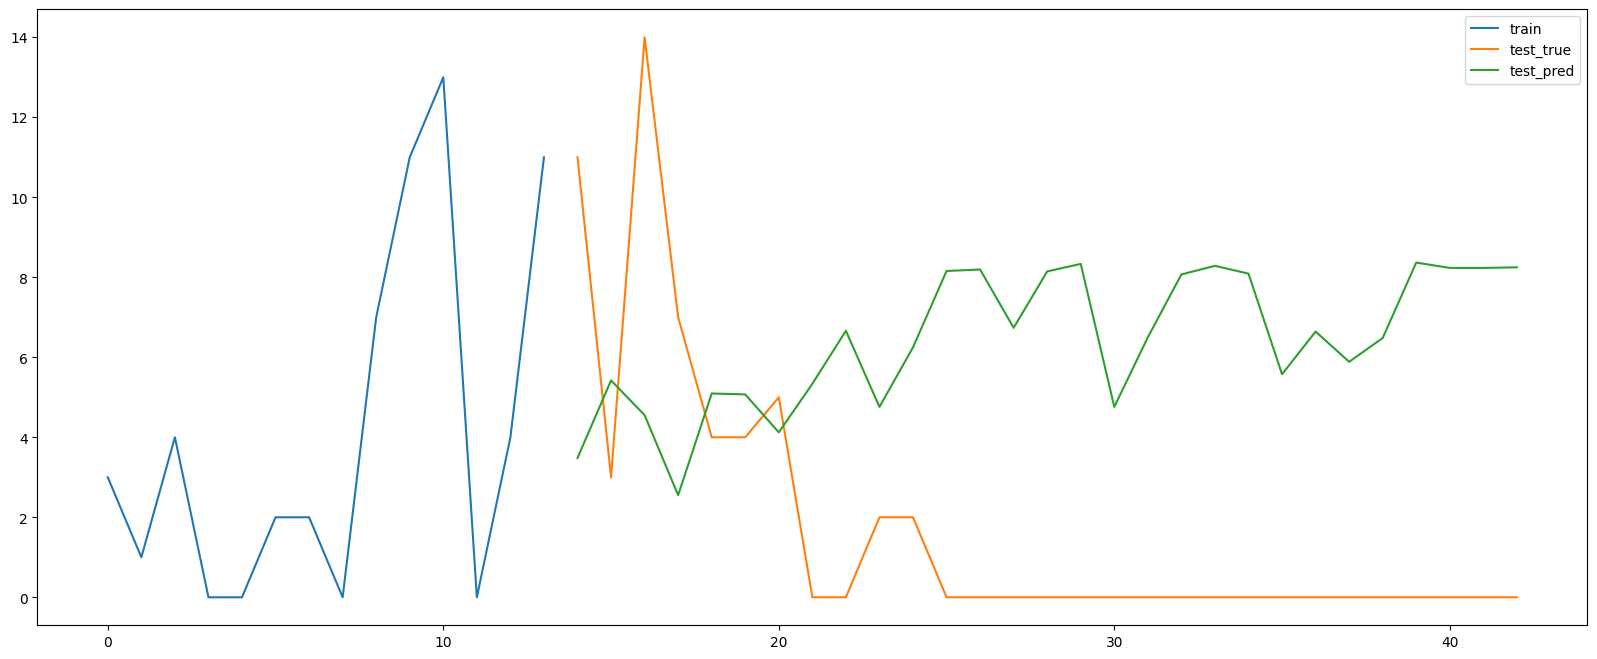

(array([3.4809325, 5.421674 , 4.5541973, 2.552204 , 5.0945473, 5.0715585,
        4.1235514, 5.3363056, 6.6618714, 4.7596054, 6.2475348, 8.156798 ,
        8.194109 , 6.738008 , 8.14619  , 8.334518 , 4.7596054, 6.5000467,
        8.071266 , 8.285957 , 8.091335 , 5.57561  , 6.642559 , 5.8867974,
        6.4815006, 8.36765  , 8.233503 , 8.233503 , 8.248774 ],
       dtype=float32),
 array([11.,  3., 14.,  7.,  4.,  4.,  5.,  0.,  0.,  2.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]))

store_id: 1, sku_id: 1, channel: 1
1/1 [==============================] - 0s 468ms/step
mse: 49.33248503428256


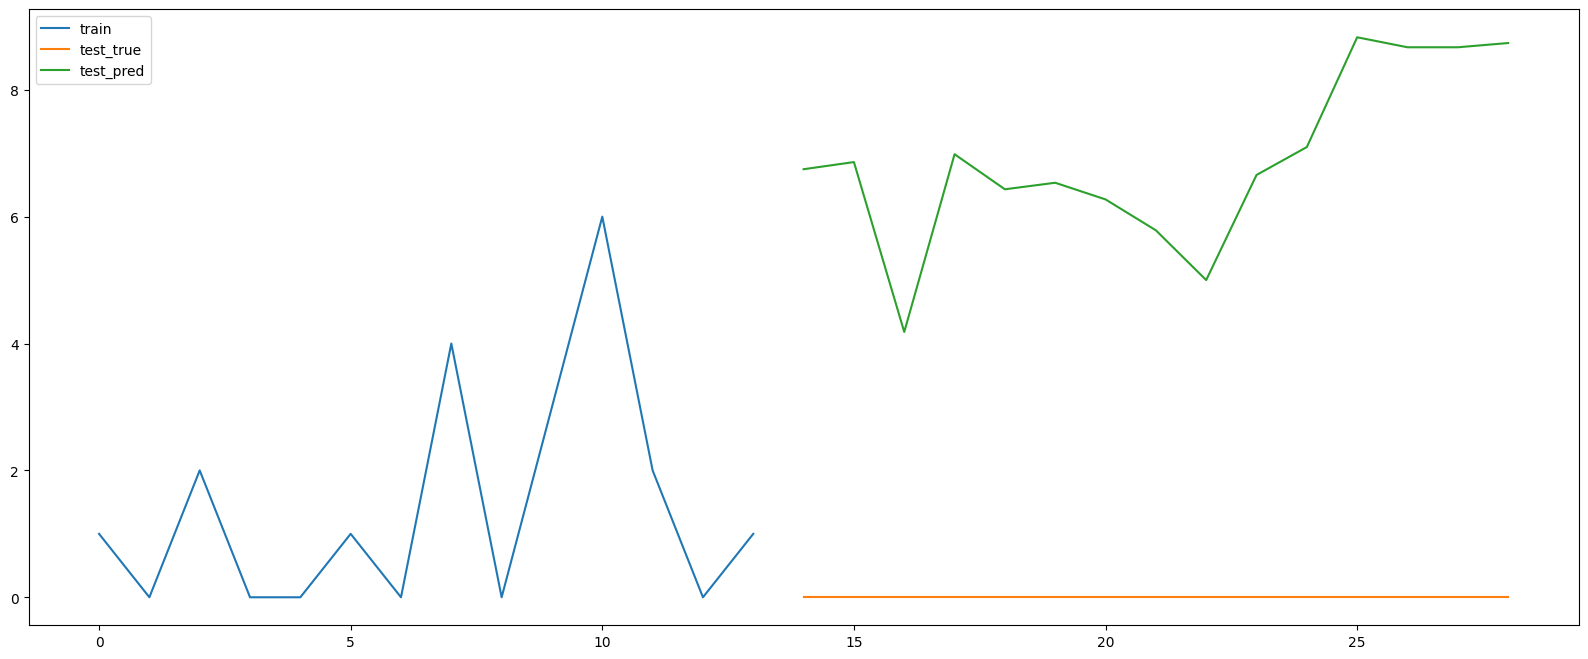

store_id: 1, sku_id: 1, channel: 2
1/1 [==============================] - 0s 468ms/step
mse: 6.601607475756514


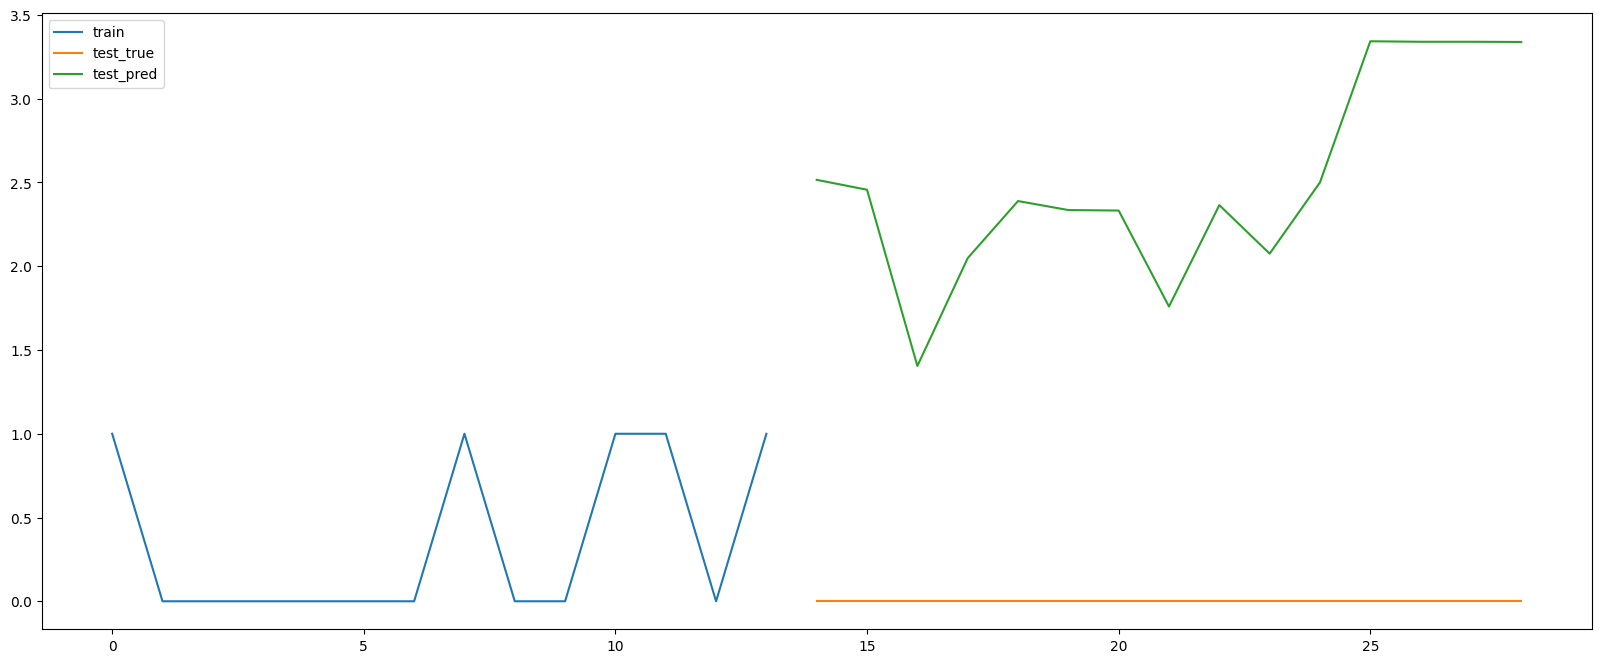

store_id: 1, sku_id: 2, channel: 1


KeyboardInterrupt: 

In [141]:
NUM_STORE = 12
NUM_SKU = 1000
NUM_CHANNEL = 2

ans = []

for store_id in range(1, NUM_STORE + 1):
    for sku_id in range(1, NUM_SKU + 1):
        for channel in range(1, NUM_CHANNEL + 1):
            print(f"store_id: {store_id}, sku_id: {sku_id}, channel: {channel}")
            label = train(store_id=store_id, sku_id=sku_id, channel=channel, split_date="2023-08-30", verbose=0)
            ans.append((store_id, sku_id, channel, label))

In [ ]:
ans

[(1,
  1,
  1,
  (array([0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0.], dtype=float32),
   array([1., 0., 2., 0., 0., 1., 0., 4., 0., 3., 6., 2., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))),
 (1,
  1,
  2,
  (array([2., 2., 2., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2.,
          1., 2., 2., 2., 3., 1., 1., 1., 1., 2., 2., 2.], dtype=float32),
   array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))),
 (1,
  2,
  1,
  (array([ 2.,  2.,  2.,  3.,  2.,  2.,  3.,  2.,  3.,  3.,  2., 10.,  2.,
           3.,  2.,  2.,  3.,  2.,  2.,  2.,  2.,  2.,  3.,  2.,  2.,  2.,
           2.,  2.,  2.], dtype=float32),
   array([2., 1., 1., 1., 1., 1., 1., 2., 3., 7., 2., 5., 4., 2., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))),
 (1,
  2,
  2,
  (array([4., 3., 3., 